This one is too simple, it's worth nothing to make a tutorial for this. I assume that anyone that heard about this already understand Langchain.

Overall it have 10 different function to work around:
- `add_edge`: Add connection from node to node
- `add_node`: Add new node
- `add_conditional_edge`: # Condition to switch branch
- `compile`: Complete all the graph flow
- `set_entry_point`: Where to start
- `set_finish_point`: Where to end
- `set_conditional_entry_point`: Multiple starting point condition to see which to start
- `add_sequence`: Linear implementation (like add edge)
- `validate`: This already happen when calling compile but can be used outsite of that
- `mro`: Debug method

Where the first 7 method is mostly used

Every logic controlling by how you define it (Use Pydantic or Typing to control and validate input)

This concept work the same with any normal graph

### Demo Code

##### Foundation

In [20]:
from typing import *
import random
from langgraph.graph import StateGraph, START, END # framework that helps you design and manage the flow of tasks in your application using a graph structure

In [2]:
# We now create an AgentState - shared data structure that keeps track of information as your application runs. 

class AgentState(Dict): # Our state schema
    message : str 


def greeting_node(state: AgentState) -> AgentState:
    """Simple node that adds a greeting message to the state"""

    state['message'] = "Hey " + state["message"] + ", how is your day going?"

    return state 

In [3]:
graph = StateGraph(AgentState)

graph.add_node("greeter", greeting_node)

graph.set_entry_point("greeter")
graph.set_finish_point("greeter")

app = graph.compile()

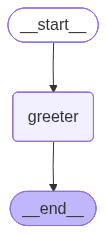

In [4]:
app

##### Sequencial

In [4]:
class AgentState2(Dict):
    name: str
    age: str
    final: str

In [7]:
def first_node(state:AgentState2) -> AgentState2:
    """This is the first node of our sequence"""

    state["final"] = "Hi" + {state["name"]} + "!"
    return state

def second_node(state:AgentState2) -> AgentState2:
    """This is the second node of our sequence"""

    state["final"] = state["final"] + f" You are " + {state["age"]} + " years old!"

    return state

In [26]:
graph = StateGraph(AgentState2)

graph.add_sequence(
    [first_node, second_node]
)

graph.set_entry_point("first_node")
graph.add_edge("first_node", "second_node")
graph.set_finish_point("second_node")
app = graph.compile()

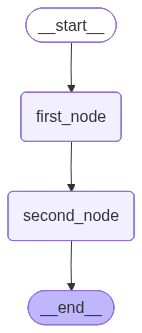

In [27]:
app

##### Multi-Input

In [10]:
class AgentState3(TypedDict):
    values: List[int]
    name: str 
    result: str 

In [11]:
def process_values(state: AgentState3) -> AgentState3:
    """This function handles multiple different inputs"""
    print(state)

    state["result"] = f"Hi there " + {state["name"]}+ "! Your sum = " + {sum(state["values"])}

    print(state)
    return state

In [12]:
graph = StateGraph(AgentState3)

graph.add_node("processor", process_values)
graph.set_entry_point("processor") # Set the starting node
graph.set_finish_point("processor") # Set the ending node

app = graph.compile() # Compiling the graph

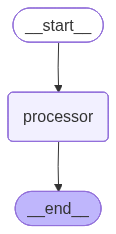

In [13]:
app

##### Condition

In [14]:
class AgentState4(TypedDict):
    number1: int 
    operation: str 
    number2: int
    finalNumber: int

In [15]:
def adder(state:AgentState4) -> AgentState4:
    """This node adds the 2 numbers"""
    state["finalNumber"] = state["number1"] + state["number2"]

    return state

def subtractor(state:AgentState4) -> AgentState4:
    """This node subtracts the 2 numbers"""
    state["finalNumber"] = state["number1"] - state["number2"]
    return state


def decide_next_node(state:AgentState4) -> AgentState4:
    """This node will select the next node of the graph"""

    if state["operation"] == "+":
        return "addition_operation"
    
    elif state["operation"] == "-":
        return "subtraction_operation" 



In [16]:
graph = StateGraph(AgentState4)

graph.add_node("add_node", adder)
graph.add_node("subtract_node", subtractor)
graph.add_node("router", lambda state:state) # passthrough function

graph.add_edge(START, "router") 

graph.add_conditional_edges(
    "router",
    decide_next_node, 

    {
        # Edge: Node
        "addition_operation": "add_node",
        "subtraction_operation": "subtract_node"
    }

)

graph.add_edge("add_node", END)
graph.add_edge("subtract_node", END)

app = graph.compile()

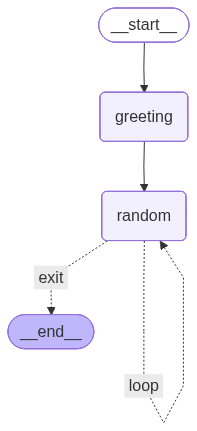

In [25]:
app

##### Looping

In [18]:
class AgentState5(TypedDict):
    name: str
    number: List[int]
    counter: int

In [22]:
def greeting_node(state: AgentState5) -> AgentState5:
    """Greeting Node which says hi to the person"""
    state["name"] = f"Hi there, " + {state["name"]}
    state["counter"] = 0 

    return state

def random_node(state: AgentState5) -> AgentState5:
    """Generates a random number from 0 to 10"""
    state["number"].append(random.randint(0, 10))
    state["counter"] += 1

    return state


def should_continue(state: AgentState5) -> AgentState5:
    """Function to decide what to do next"""
    if state["counter"] < 5:
        print("ENTERING LOOP", state["counter"])
        return "loop"  # Continue looping
    else:
        return "exit"  # Exit the loop
    

In [29]:
graph = StateGraph(AgentState5)

graph.add_node("greeting", greeting_node)
graph.add_node("random", random_node)
graph.add_edge("greeting", "random")


graph.add_conditional_edges(
    "random",     # Source node
    should_continue, # Action
    {
        "loop": "random",  
        "exit": END          
    }
)

graph.set_entry_point("greeting")

app = graph.compile()

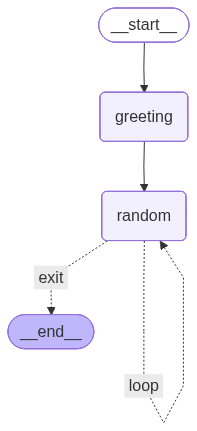

In [24]:
app

In [36]:
for i, cls in enumerate(StateGraph.mro()):
    print(f"{i + 1}. {cls.__name__}")

1. StateGraph
2. Generic
3. object
